In [73]:
import os
import numpy as np
from PIL import Image

def load_and_downsample_images(image_folder, max_dim=500):
    images = []
    image_shapes = []
    image_names = []
    
    for filename in sorted(os.listdir(image_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            img = Image.open(image_path).convert('RGB')
            w, h = img.size
            scale = min(max_dim / w, max_dim / h, 1)  # Only downscale
            new_size = (int(w * scale), int(h * scale))
            img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            pixels = img_np.reshape(-1, 3)
            images.append(pixels)
            image_shapes.append(img_np.shape[:2])  # (height, width)
            image_names.append(filename)
    
    return images, image_shapes, image_names

# Example usage
image_folder = 'C:/Users/RCOM/Desktop/K-means Challenge/Images'
images, image_shapes, image_names = load_and_downsample_images(image_folder)


In [74]:
from sklearn.cluster import MiniBatchKMeans

def segment_image_minibatch_kmeans(features, k, image_shape):
    h, w = image_shape
    kmeans = MiniBatchKMeans(
    n_clusters=k,
    batch_size=10000,
    init="k-means++",
    random_state=42,
    n_init=10
)

    labels = kmeans.fit_predict(features)
    centers_rgb = kmeans.cluster_centers_[:, :3].astype(np.uint8)

    segmented_flat = centers_rgb[labels]
    segmented_img = segmented_flat.reshape(h, w, 3)
    return segmented_img, labels


In [75]:
def extract_rgb_xy_features(image_pixels, image_shape):
    height, width = image_shape
    x_coords = np.tile(np.arange(width), height) / width
    y_coords = np.repeat(np.arange(height), width) / height
    features = np.column_stack((image_pixels, x_coords, y_coords))
    return features

def extract_features_for_all(images, image_shapes):
    all_features = []
    for img_pixels, shape in zip(images, image_shapes):
        features = extract_rgb_xy_features(img_pixels, shape)
        all_features.append(features)
    return all_features

# Run this line to create the variable before clustering:
features_all_images = extract_features_for_all(images, image_shapes)


In [76]:
def extract_features_for_all(images, image_shapes):
    all_features = []
    for img_pixels, shape in zip(images, image_shapes):
        features = extract_rgb_xy_features(img_pixels, shape)
        all_features.append(features)
    return all_features


features_all_images = extract_features_for_all(images, image_shapes)

# Check the shape of features for the first image
print(f'Features shape for first image: {features_all_images[0].shape}') 


Features shape for first image: (187125, 5)


In [77]:
import cv2

def apply_gaussian_blur(image_np, kernel_size=(5, 5), sigma=0):
    """
    Apply Gaussian blur to a NumPy image array.
    
    Parameters:
    - image_np: numpy array of shape (height, width, 3) in RGB format.
    - kernel_size: Gaussian kernel size, e.g., (5,5).
    - sigma: Gaussian kernel standard deviation. 0 means auto-calculated.
    
    Returns:
    - blurred_image_rgb: blurred image in RGB format, same shape as input.
    """
    # Convert RGB to BGR for OpenCV
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    blurred_bgr = cv2.GaussianBlur(image_bgr, kernel_size, sigma)
    blurred_rgb = cv2.cvtColor(blurred_bgr, cv2.COLOR_BGR2RGB)
    return blurred_rgb

# Example to apply blur to all loaded images and then extract features:

def load_and_blur_images(image_folder):
    blurred_images = []
    image_shapes = []
    image_names = []
    
    for filename in sorted(os.listdir(image_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            img = Image.open(image_path).convert('RGB')
            img_np = np.array(img)
            blurred_img = apply_gaussian_blur(img_np)
            height, width, _ = blurred_img.shape
            pixels = blurred_img.reshape(-1, 3)
            blurred_images.append(pixels)
            image_shapes.append((height, width))
            image_names.append(filename)
    
    return blurred_images, image_shapes, image_names



In [78]:
import cv2
import numpy as np
from PIL import Image

def load_downsample_and_blur(image_folder, max_dim=500, ksize=(5,5), sigma=0):
    images_rgb = []
    image_shapes = []
    image_names = []

    for filename in sorted(os.listdir(image_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(image_folder, filename)
            img = Image.open(path).convert('RGB')
            w, h = img.size
            scale = min(max_dim / w, max_dim / h, 1.0)
            new_size = (int(w*scale), int(h*scale))
            img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)

            # Gaussian blur in OpenCV
            img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
            img_blur = cv2.GaussianBlur(img_bgr, ksize, sigma)
            img_rgb_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)

            images_rgb.append(img_rgb_blur)
            image_shapes.append(img_rgb_blur.shape[:2])
            image_names.append(filename)

    return images_rgb, image_shapes, image_names


In [79]:
from sklearn.cluster import KMeans
import numpy as np

def segment_image_kmeans(features, k, image_shape):
  
    h, w = image_shape
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = kmeans.fit_predict(features)

    # Use cluster centers’ RGB (first 3 dims) as segment colors
    centers_rgb = kmeans.cluster_centers_[:, :3].astype(np.uint8)

    segmented_flat = centers_rgb[labels]
    segmented_img = segmented_flat.reshape(h, w, 3)
    return segmented_img, labels

# Example for one image (index 0), for all K in {2,3,4,5}
Ks = [2, 3, 4, 5]
segmented_results = {}  

for idx, (features, shape) in enumerate(zip(features_all_images, image_shapes)):
    print(f"Processing {image_names[idx]}...")
    segmented_results[idx] = {}
    for k in Ks:
        seg_img, labels = segment_image_kmeans(features, k, shape)
        segmented_results[idx][k] = {
            "image": seg_img,
            "labels": labels
        }


Processing image1.jpg...
Processing image10.jpg...
Processing image11.jpg...
Processing image12.png...
Processing image13.jpg...
Processing image14.jpg...
Processing image15.jpg...
Processing image2.jpg...
Processing image3.jpg...
Processing image4.jpg...
Processing image5.jpg...
Processing image6.jpg...
Processing image7.jpg...
Processing image8.jpg...
Processing image9.jpg...


In [80]:
def choose_best_k_elbow(img_rgb, k_min=2, k_max=10, down_size=100):
    """
    Downsamples the image, runs K-Means with multiple k values,
    computes WCSS (elbow method) and returns the best k.
    """

    # --- 1. Downsample for faster clustering ---
    img_small = cv2.resize(img_rgb, (down_size, down_size))
    pixels = img_small.reshape(-1, 3).astype(np.float32)

    # K-Means criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
                100, 0.2)

    wcss = []
    ks = range(k_min, k_max + 1)

    # --- 2. Compute WCSS for each k ---
    for k in ks:
        _, labels, centers = cv2.kmeans(
            pixels, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS
        )
        labels = labels.flatten()

        # Compute compactness (WCSS)
        distances = np.linalg.norm(pixels - centers[labels], axis=1)
        wcss.append(np.sum(distances))

    # --- 3. Automatic Elbow Detection ---
    # Compute the curve's second derivative
    diffs = np.diff(wcss)
    second_diffs = np.diff(diffs)

    # Elbow is where curvature is maximum (largest 2nd derivative)
    elbow_index = np.argmax(second_diffs) + 2  # +2 to offset diff shifts
    best_k = elbow_index

    # --- 4. Optional: Plot Elbow Curve ---
    # plt.figure(figsize=(8, 5))
    # plt.plot(ks, wcss, marker="o")
    # plt.axvline(best_k, color="red", linestyle="--", label=f"Chosen k = {best_k}")
    # plt.title("Elbow Method (Downsampled)")
    # plt.xlabel("Number of clusters (k)")
    # plt.ylabel("WCSS")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    return best_k

In [81]:
# K-Means parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [82]:
pixel_values = img_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

In [83]:
# Apply K-Means
k = choose_best_k_elbow(img_rgb)  # number of clusters
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

In [ ]:
labels = labels.flatten()      
# Convert centers back to 8-bit values
centers = np.uint8(centers)

# Map each pixel to the center of the cluster it belongs to
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img_rgb.shape)

In [85]:
# --- Parameters ---
kernel = np.ones((7,7), np.uint8)  # morphological kernel

# Assume you already have:
# img_rgb, pixel_values, criteria, k, labels, centers, segmented_image

# Reshape labels to 2D
h, w = img_rgb.shape[:2]
labels_2d = labels.reshape(h, w)

# Create a clean segmented image
segmented_clean = np.zeros_like(segmented_image)

# Process each cluster separately
for i, center_color in enumerate(centers):
    # Create binary mask for cluster i
    mask = (labels_2d == i).astype(np.uint8) * 255
    
    # --- Morphological operations ---
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # fill small holes

    # Apply mask to assign cluster color
    segmented_clean[mask == 255] = center_color

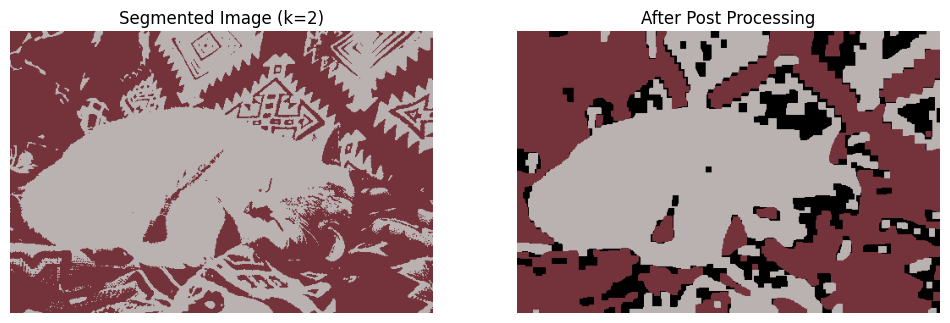

In [86]:
# Display using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title(f"Segmented Image (k={k})")
plt.imshow(segmented_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"After Post Processing")
plt.imshow(segmented_clean)
plt.axis("off")

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

def sampled_silhouette(features, labels, sample_size=2000):
    """
    Calculate silhouette score using a small random sample (for speed).
    """
    n = len(features)


    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        features_sample = features[idx]
        labels_sample = labels[idx]
    else:
        features_sample = features
        labels_sample = labels

    return silhouette_score(features_sample, labels_sample)


silhouette_results = {}

max_images_for_sil = 5          # limit number of images
sample_size = 2000              # smaller, faster sample

for idx, (features, shape) in enumerate(zip(features_all_images, image_shapes)):
    if idx >= max_images_for_sil:
        break  # stop after first N images

    silhouette_results[idx] = {}

    for k in Ks:
        labels = segmented_results[idx][k]["labels"]
        score = sampled_silhouette(features, labels, sample_size=sample_size)
        silhouette_results[idx][k] = score
        print(f"Sampled Silhouette for image {image_names[idx]}, K={k}: {score:.4f}")


Sampled Silhouette for image image1.jpg, K=2: 0.5521
Sampled Silhouette for image image1.jpg, K=3: 0.5945
Sampled Silhouette for image image1.jpg, K=4: 0.4546
Sampled Silhouette for image image1.jpg, K=5: 0.5005
Sampled Silhouette for image image10.jpg, K=2: 0.4483
Sampled Silhouette for image image10.jpg, K=3: 0.4013
Sampled Silhouette for image image10.jpg, K=4: 0.4232
Sampled Silhouette for image image10.jpg, K=5: 0.3277
Sampled Silhouette for image image11.jpg, K=2: 0.9001
Sampled Silhouette for image image11.jpg, K=3: 0.8901
Sampled Silhouette for image image11.jpg, K=4: 0.8712
Sampled Silhouette for image image11.jpg, K=5: 0.8547
Sampled Silhouette for image image12.png, K=2: 0.6527
Sampled Silhouette for image image12.png, K=3: 0.5477
Sampled Silhouette for image image12.png, K=4: 0.5412
Sampled Silhouette for image image12.png, K=5: 0.5078
Sampled Silhouette for image image13.jpg, K=2: 0.4897
Sampled Silhouette for image image13.jpg, K=3: 0.5273
Sampled Silhouette for image ima

In [88]:
from sklearn.cluster import MiniBatchKMeans

def segment_from_lab_xy(features, k, image_shape):
    h, w = image_shape
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=10000,
        init="k-means++",
        random_state=42
    )
    labels = kmeans.fit_predict(features)

    # Use cluster centers' Lab → convert to RGB for visualization
    centers_lab = kmeans.cluster_centers_[:, :3].astype(np.uint8)

    # Map each pixel to its center Lab, reshape to image, then Lab→RGB
    lab_img_flat = centers_lab[labels]
    lab_img = lab_img_flat.reshape(h, w, 3)
    lab_img_bgr = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    lab_img_rgb = cv2.cvtColor(lab_img_bgr, cv2.COLOR_BGR2RGB)

    return lab_img_rgb, labels


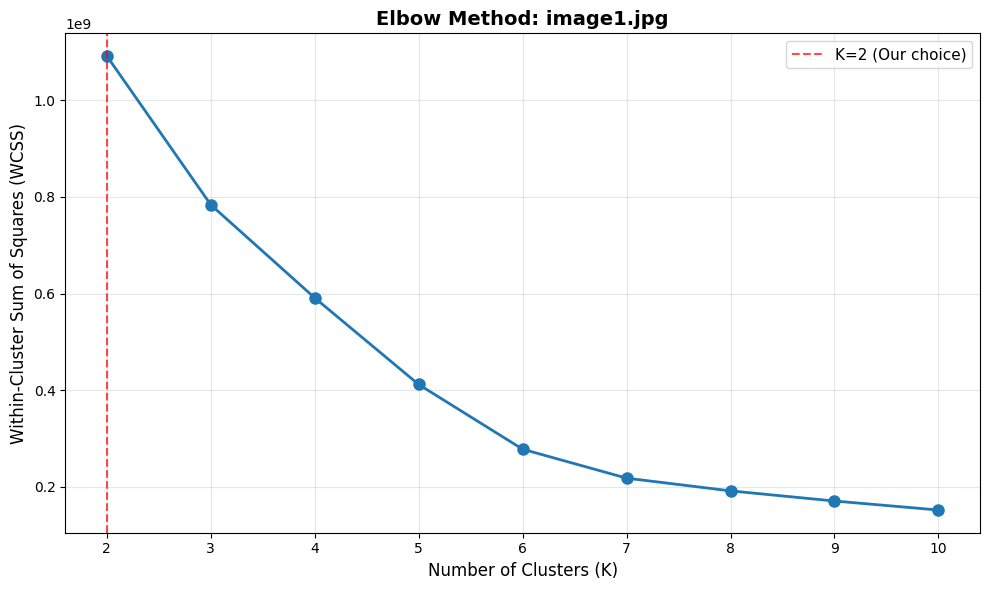


=== Elbow Method Analysis ===
Image: image1.jpg
WCSS values: [1091414528.8836074, 783581696.3863399, 590895380.7987493, 411689539.1469845, 277752162.55306065, 217895922.7394175, 191536647.0943579, 170566568.20353353, 151931652.57862213]
K=2 WCSS: 1091414528.88
K=3 WCSS: 783581696.39
Difference: 307832832.50 (% change: 28.2%)


In [89]:
# ============================================
# BONUS: Elbow Method Validation
# ============================================

import matplotlib.pyplot as plt

def elbow_method_analysis(features, image_idx, image_name, k_range=[2, 3, 4, 5, 6, 7, 8, 9, 10]):
    """
    Compute WCSS (Within-Cluster Sum of Squares) for different K values.
    This helps validate if K=2 or K=3 is truly optimal.
    """
    from sklearn.cluster import KMeans
    
    wcss = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)  # inertia = within-cluster sum of squares
    
    return wcss

# Run elbow analysis on first image as example
idx = 0
wcss = elbow_method_analysis(features_all_images[idx], idx, image_names[idx])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axvline(x=2, color='red', linestyle='--', alpha=0.7, label='K=2 (Our choice)')
plt.title(f'Elbow Method: {image_names[idx]}', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n=== Elbow Method Analysis ===")
print(f"Image: {image_names[idx]}")
print(f"WCSS values: {wcss}")
print(f"K=2 WCSS: {wcss[0]:.2f}")
print(f"K=3 WCSS: {wcss[1]:.2f}")
print(f"Difference: {abs(wcss[0] - wcss[1]):.2f} (% change: {abs(wcss[0] - wcss[1])/wcss[0]*100:.1f}%)")


In [90]:
import os
from PIL import Image
import numpy as np

image_folder = "C:/Users/RCOM/Desktop/K-means Challenge/Images"   # <-- set your folder

images_rgb = []
image_shapes = []
image_names = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        path = os.path.join(image_folder, filename)
        img = Image.open(path).convert("RGB")

        # Optional: downsample to control RAM
        max_dim = 500
        w, h = img.size
        scale = min(max_dim / w, max_dim / h, 1.0)
        new_size = (int(w * scale), int(h * scale))
        img_resized = img.resize(new_size, Image.Resampling.LANCZOS)

        img_np = np.array(img_resized)          # H x W x 3 RGB
        images_rgb.append(img_np)
        image_shapes.append(img_np.shape[:2])   # (H, W)
        image_names.append(filename)

print(len(images_rgb), "images loaded")
print("First image shape:", images_rgb[0].shape)


15 images loaded
First image shape: (375, 499, 3)


In [91]:
import cv2
import numpy as np

def extract_lab_xy_features(image_rgb):
    h, w, _ = image_rgb.shape

    # RGB -> Lab
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    lab_flat = image_lab.reshape(-1, 3).astype(np.float32)

    # Normalized coordinates
    x_coords = np.tile(np.arange(w), h) / float(w)
    y_coords = np.repeat(np.arange(h), w) / float(h)
    coords = np.column_stack((x_coords, y_coords)).astype(np.float32)

    features = np.hstack([lab_flat, coords])
    return features

lab_xy_features_all = []
for img_rgb in images_rgb:        
    feats = extract_lab_xy_features(img_rgb)
    lab_xy_features_all.append(feats)

print(len(lab_xy_features_all), lab_xy_features_all[0].shape)


15 (187125, 5)


In [92]:
from sklearn.cluster import MiniBatchKMeans
import cv2
import numpy as np

def segment_from_lab_xy(features, k, image_shape):
    h, w = image_shape

    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=10000,
        init="k-means++",
        random_state=42
    )
    labels = kmeans.fit_predict(features)

    centers_lab = kmeans.cluster_centers_[:, :3].astype(np.uint8)
    lab_img_flat = centers_lab[labels]
    lab_img = lab_img_flat.reshape(h, w, 3)

    lab_bgr = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    lab_rgb = cv2.cvtColor(lab_bgr, cv2.COLOR_BGR2RGB)

    return lab_rgb, labels


In [93]:
import os
import numpy as np
from PIL import Image

image_folder = "C:/Users/RCOM/Desktop/K-means Challenge/Images"  

def load_and_downsample_images(image_folder, max_dim=500):
    images = []
    image_shapes = []
    image_names = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(image_folder, filename)
            img = Image.open(path).convert('RGB')
            w, h = img.size
            scale = min(max_dim / w, max_dim / h, 1.0)
            new_size = (int(w*scale), int(h*scale))
            img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            images.append(img_np)
            image_shapes.append(img_np.shape[:2])
            image_names.append(filename)
    return images, image_shapes, image_names

images, image_shapes, image_names = load_and_downsample_images(image_folder)


In [94]:
from sklearn.metrics import silhouette_score
import numpy as np

def sampled_silhouette(pixel_values, labels, sample_size=5000):
    """
    Calculate silhouette score using random sample (for speed).
    """
    n = len(pixel_values)
    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        X_sample = pixel_values[idx]
        y_sample = labels[idx]
    else:
        X_sample = pixel_values
        y_sample = labels
    return silhouette_score(X_sample, y_sample)

# Usage example:
score = sampled_silhouette(pixel_values, labels, sample_size=5000)
print("Silhouette Score (sampled):", score)


Silhouette Score (sampled): -0.057910844683647156


In [95]:
from PIL import Image as PILImage
import os

output_folder = "output_segments"
os.makedirs(output_folder, exist_ok=True)

for idx, name in enumerate(image_names):
    for k in Ks:
        # Get segmented image
        seg_img = segmented_results[idx][k]["image"]
        
        # Create output filename
        base_name = os.path.splitext(name)[0]
        output_name = f"{base_name}_segmentedK{k}.png"
        output_path = os.path.join(output_folder, output_name)
        
        # Save as PNG
        PILImage.fromarray(seg_img).save(output_path)
        print(f"Saved: {output_path}")

Saved: output_segments\image1_segmentedK2.png
Saved: output_segments\image1_segmentedK3.png
Saved: output_segments\image1_segmentedK4.png
Saved: output_segments\image1_segmentedK5.png
Saved: output_segments\image10_segmentedK2.png
Saved: output_segments\image10_segmentedK3.png
Saved: output_segments\image10_segmentedK4.png
Saved: output_segments\image10_segmentedK5.png
Saved: output_segments\image11_segmentedK2.png
Saved: output_segments\image11_segmentedK3.png
Saved: output_segments\image11_segmentedK4.png
Saved: output_segments\image11_segmentedK5.png
Saved: output_segments\image12_segmentedK2.png
Saved: output_segments\image12_segmentedK3.png
Saved: output_segments\image12_segmentedK4.png
Saved: output_segments\image12_segmentedK5.png
Saved: output_segments\image13_segmentedK2.png
Saved: output_segments\image13_segmentedK3.png
Saved: output_segments\image13_segmentedK4.png
Saved: output_segments\image13_segmentedK5.png
Saved: output_segments\image14_segmentedK2.png
Saved: output_seg